In [1]:
from cobra.io import read_sbml_model

nj4 = read_sbml_model("GEMs/NJ4_curated.xml")
m5 = read_sbml_model("GEMs/M5_curated.xml")

## static sim

look into the possibilities for crossfeeding

## dynamic sim
sequential community

In [4]:
import pandas as pd

media_db = pd.read_csv("medium.tsv", sep="\t")

m5_med = media_db[media_db["medium"] == "m5_med"]

UNLIMITED_METABOLITES = ['ca2_e', 'cl_e', 'cobalt2_e', 'cu2_e', 'fe2_e', 'fe3_e','h_e', 'k_e', 'h2o_e', 'mg2_e', 
                    'mn2_e', 'mobd_e', 'na1_e', 'nh4_e', 'ni2_e', 'pi_e', 'so4_e', 'zn2_e']

medium = [str(m+"_e") for m in m5_med["compound"].tolist()]
added_metabilotes = set(medium) - set(UNLIMITED_METABOLITES)
added_metabilotes = {k:0.5 for k in added_metabilotes}

# TODO: calculate xylan (60 g/L concentration) to an amount of moles that makes sense
added_metabilotes["xylan4_e"] = 10
added_metabilotes["xylan8_e"] = 10

#added_metabilotes["xyl__D_e"] = 2 #TODO: remove

INOC_TIME = 3

In [20]:
# NOTE: these param vals mean nothing, I am just testning something out
kinetic_params = {"NJ4": {"vmax": {"EX_xyl__D_e": 10}}, "M5": {"vmax": {"EX_xyl__D_e": 0.05, "xylan4_e": 0.1}}}

In [26]:
from utils import comets_functions as cf

first_sim, second_sim = cf.sequental_com(m5, nj4, init_medium=added_metabilotes, total_sim_time=10, inoc_time=INOC_TIME, initial_pop_m5=0.0001, kinetic_params=kinetic_params)

reaction couldnt be found

Running COMETS simulation ...
Done!
reaction couldnt be found

Running COMETS simulation ...
Done!


In [27]:
bm, met, flux = cf.collapse_sequential_sim(first_sim, second_sim)

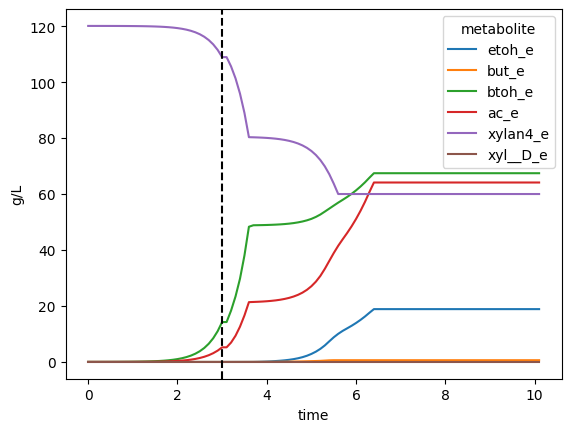

In [29]:
metabolites = ["xyl__D_e", "etoh_e", "but_e", "btoh_e", "ac_e", "xylan4_e"]

cf.plot_metabolites(metabolites_time_series=met, metabolites=metabolites, inoc_time=INOC_TIME)

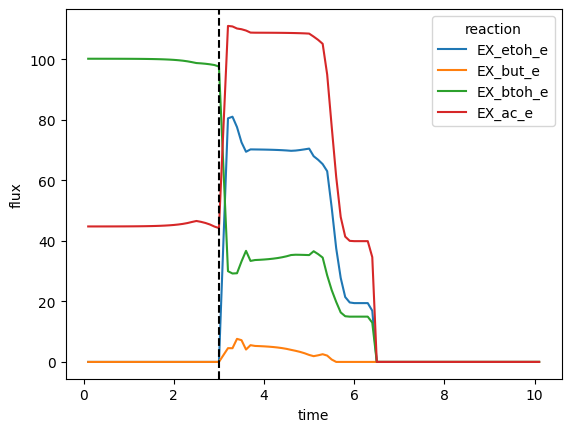

In [30]:
production_reactions = ["EX_etoh_e", "EX_but_e", "EX_btoh_e", "EX_ac_e"]

cf.plot_reaction_flux(fluxes=flux, reactions=production_reactions, inoc_time=INOC_TIME)

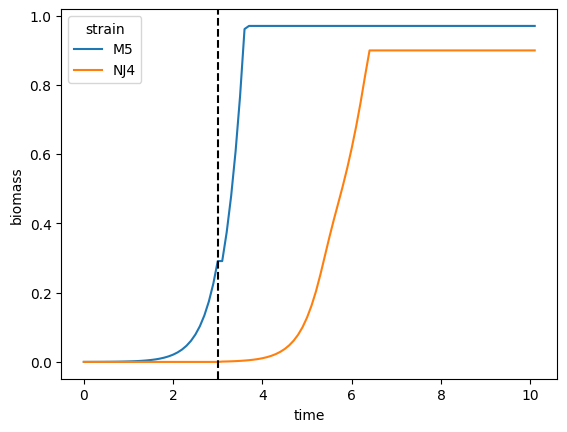

In [28]:
cf.plot_biomass(total_biomass=bm, inoc_time=INOC_TIME)